In [89]:
!export TF_BLAS=libopenblas
!export LD_LIBRARY_PATH=/usr/lib/x86_64-linux-gnu:$LD_LIBRARY_PATH
!export OPENBLAS_NUM_THREADS=8  # You can adjust this based on your CPU cores

In [90]:
import pandas as pd
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import glob

# Data

In [91]:
# construct dataframe from multiple csv files

# get list of available csv files
csv_files = glob.glob('./data/*.csv')

# read each file and create final df
dataframes = []
for file in csv_files:
    temp_df = pd.read_csv(file)
    dataframes.append(temp_df)

df = pd.concat(dataframes, ignore_index=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')  # convert unix_train time to date time
df.sort_values(by='Timestamp', inplace=True)  # sort by timestamp

In [92]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88801 entries, 82354 to 43821
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Number     88801 non-null  float64       
 1   Timestamp  88801 non-null  datetime64[ns]
 2   IP         88801 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.7+ MB


Number       0
Timestamp    0
IP           0
dtype: int64

# Feature Eng.

In [93]:
n_features = 3  # number of features used to train
n_lookback = 5  # Number of historical data points to learn for each result

In [94]:
def get_time_attr(row: pd.Series, part: str):
    """Return the specified part of the timestamp.

    Args:
        row (pd.Series): Dataframe row
        part (str): Should be a valid `pandas.Timestamp` attribute

    Returns:
        any: Specified attribute of the timestamp
    """
    return getattr(row, part)

In [95]:
# Get time attributes and add to dataframe
needed_time_attrs = ["hour", "minute"]

for attr in needed_time_attrs:
    df[attr] = df["Timestamp"].apply(lambda x: get_time_attr(x, attr))


# Data preprocessing

In [96]:
# train test split
train_fraction = 0.8
split_point = int(len(df) * train_fraction)

df_train = df.iloc[:split_point]
df_test = df.iloc[split_point:]

In [97]:
# raw sequence data
train_raw_seq = np.array(df_train[["Number", "hour", "minute"]])
# n_features = train_raw_seq.shape[-1]  # Number of features being used

In [98]:
# look back sequences
def split_sequence(sequence: np.ndarray, num_steps: int, num_features: int):
    """Make sub sequences of n length and the prediction value and return them

    Args:
        sequence (numpy.ndarray): The sequence of training data
        num_steps (int): How many past data points to look at
        num_features (int): Total number of features in given dataset
    """

    x, y = [], []

    for i in range(len(sequence)):
        # find index of end of current learning slice
        end_i = i + num_steps

        # check if end is beyond the length of sequence
        if end_i > len(sequence) - 1:  # -1 since last element needs to be the prediction value
            break
        else:
            seq_x = sequence[i:end_i]  # training sequence
            seq_y = sequence[end_i][0]  # prediction value should only be the Number

            x.append(seq_x)
            y.append(seq_y)

    # Reshape data
    x = np.array(x)
    y = np.array(y)

    x = x.reshape(x.shape[0], x.shape[1], num_features)  # each internal array contains data of each timestep
    y = y.reshape(-1, 1)
    
    return x, y

In [99]:
# Get train, test splits
X_train, y_train = split_sequence(train_raw_seq, n_lookback, n_features)

# Models

In [100]:
# construct model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def train_model(X_train: np.array, y_train: np.array, num_features: int, num_lookback: int, activation: str, num_epochs: int, optimizer: str ='adam', loss: str ='mean_squared_logarithmic_error'):
    # define model
    model = Sequential()

    # Primary layer
    model.add(LSTM(1, activation=activation, input_shape=(num_lookback, num_features)))

    # Dense layers
    model.add(Dense(64, activation=activation))
    model.add(Dense(64, activation=activation))
    # model.add(Dense(64, activation=activation))
    # model.add(Dense(64, activation=activation))
    
    
    # Output layer
    model.add(Dense(1))


    model.compile(optimizer=optimizer, loss=loss)

    # fit model
    history = model.fit(X_train, y_train, epochs=num_epochs, verbose=1, validation_split=0.2)

    # Print realtime loss plots
    

    # plot train and validation loss
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Train", "Validation"], loc="upper right")
    plt.show()

    # return trained model object
    return model

Epoch 1/15


1776/1776 [==============================] - 4s 2ms/step - loss: 14.1695 - val_loss: 14.2482
Epoch 2/15
1776/1776 [==============================] - 3s 2ms/step - loss: 14.1695 - val_loss: 14.2482
Epoch 3/15
1776/1776 [==============================] - 3s 2ms/step - loss: 14.1695 - val_loss: 14.2482
Epoch 4/15
1776/1776 [==============================] - 3s 2ms/step - loss: 14.1695 - val_loss: 14.2482
Epoch 5/15
1776/1776 [==============================] - 3s 2ms/step - loss: 14.1694 - val_loss: 14.2482
Epoch 6/15
1776/1776 [==============================] - 3s 2ms/step - loss: 14.1694 - val_loss: 14.2482
Epoch 7/15
1776/1776 [==============================] - 3s 2ms/step - loss: 14.1694 - val_loss: 14.2482
Epoch 8/15
1776/1776 [==============================] - 3s 2ms/step - loss: 14.1695 - val_loss: 14.2482
Epoch 9/15
1776/1776 [==============================] - 3s 2ms/step - loss: 14.1695 - val_loss: 14.2482
Epoch 10/15
1776/1776 [==============================] - 3s 2ms/step - loss

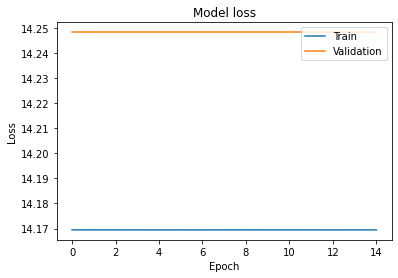

In [101]:
# Sigmoid
model = train_model(X_train, y_train, n_features, n_lookback, 'sigmoid', 15, optimizer='adam')

In [102]:
# save model to file
model_2_path = './models/02-hour_min-2_dense-50-epochs_-sigmoid.keras'
model_2.save(model_2_path)

NameError: name 'model_2' is not defined

# Evaluate

In [103]:
# define evaluate function
def evaluate_msle(model: tensorflow.keras.models.Sequential, preds: np.array, ground_truths: np.array):
    m = tensorflow.keras.metrics.MeanSquaredLogarithmicError()
    m.update_state(ground_truths, preds)
    metric = m.result().numpy()
    m.reset_state()
    return metric

In [104]:
# test data
test_raw_seq = np.array(df_test[["Number", "hour", "minute"]])
X_test, y_test = split_sequence(test_raw_seq, n_lookback, n_features)

In [105]:
# make predictions
# preds_1 = model_1.predict(X_test)
preds = model.predict(X_test)

555/555 [==============================] - 0s 649us/step


In [108]:
# print("Model 1 MSLE: ", evaluate_msle(model_1, preds_1, y_test))
print("Model 2 MSLE: ", evaluate_msle(model, preds, y_test))

Model 2 MSLE:  14.194802


In [109]:
preds

array([[-0.9980898 ],
       [-0.9980898 ],
       [-0.9980898 ],
       ...,
       [-0.99808997],
       [-0.9980898 ],
       [-0.99808985]], dtype=float32)